In [17]:
from datetime import datetime
from datetime import datetime, timedelta
from findatapy.market import Market, MarketDataRequest, MarketDataGenerator
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import redis
import seaborn as sns
import time
import undetected_chromedriver as uc

# Manually set the start date and end date
start_date = datetime(2021, 1, 25)
end_date = datetime(2021, 1, 31)

# Filters for news scraping
desired_currencies = ["EUR", "USD"]
desired_impacts = ["Medium Impact Expected", "High Impact Expected"]

# Define forex pairs for correlation, ordered alphabetically
forex_pairs = sorted(['EURUSD', 'GBPUSD', 'USDJPY', 'AUDUSD', 'USDCHF', 'USDCAD', 'NZDUSD'])

# Resampling timeframe (h must be lower)
new_timeframe = '4h'

# ChromeDriver Path
chrome_path = "C:/Program Files/Google/Chrome/Application/chrome.exe"

In [12]:
# Initialize Redis client
redis_client = redis.StrictRedis(host='localhost', port=6379, db=0)

# Generate the list of dates in the format needed for the URL
def generate_date_list(start_date, end_date):
    return [(start_date + timedelta(days=x)).strftime('%b%d.%Y').lower() for x in range((end_date - start_date).days + 1)]

# Format date to "Day, Number Month"
def format_date_for_table(date_str):
    date_obj = datetime.strptime(date_str, '%b%d.%Y')
    return date_obj.strftime('%A, %d %B')

# Setup Chrome options for Selenium
chrome_options = Options()
chrome_options.binary_location = chrome_path
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Initialize undetected ChromeDriver
driver = uc.Chrome(options=chrome_options, use_subprocess=True)

# Prepare to store all collected data
all_events = []

# Function to fetch data for the given date range
def fetch_data_for_date_range(start_date, end_date):
    date_list = generate_date_list(start_date, end_date)
    
    for date in date_list:
        # Check if data for this date is in the Redis cache
        cached_data = redis_client.get(date)
        if cached_data:
            print(f"Loading data from cache...")
            events = pickle.loads(cached_data)
            all_events.extend(events)
            continue  # Skip to the next date
        
        # Generate the URL for the current date
        url = f"https://www.forexfactory.com/calendar?day={date}"
        
        # Navigate to the page
        driver.get(url)
        
        # Wait for the page to fully load
        time.sleep(1)
        
        # Locate the table or section containing the calendar events
        try:
            calendar_table = driver.find_element(By.CSS_SELECTOR, 'table.calendar__table')
        except Exception as e:
            print(f"Error loading data for {date}: {e}")
            continue
        
        # Initialize variable to keep track of the current time
        current_time = None
        formatted_date = format_date_for_table(date)  # Format the date for the table
        events = []  # Store events for this date
        
        # Loop through each row in the table
        for row in calendar_table.find_elements(By.CSS_SELECTOR, 'tr.calendar__row'):
            # Extract the time from the td with class calendar__time
            try:
                time_elem = row.find_element(By.CSS_SELECTOR, 'td.calendar__time > div > span')
                current_time = time_elem.text.strip() if time_elem.text.strip() else current_time
            except:
                current_time = current_time  # Keep the last known time

            # Extract the currency from the td with class calendar__currency
            try:
                currency_elem = row.find_element(By.CSS_SELECTOR, 'td.calendar__currency > span')
                currency = currency_elem.text.strip()
            except:
                currency = ""

            # Extract the impact title from the td with class calendar__impact
            try:
                impact_elem = row.find_element(By.CSS_SELECTOR, 'td.calendar__impact > span')
                impact = impact_elem.get_attribute('title').strip()
            except:
                impact = ""

            # Extract the event name from the td with class calendar__event
            try:
                event_elem = row.find_element(By.CSS_SELECTOR, 'td.calendar__event > div > span')
                event_name = event_elem.text.strip()
            except:
                event_name = ""

            # Extract the actual value from the td with class calendar__actual
            try:
                actual_elem = row.find_element(By.CSS_SELECTOR, 'td.calendar__actual > span')
                actual = actual_elem.text.strip()
            except:
                actual = ""

            # Extract the forecast value from the td with class calendar__forecast
            try:
                forecast_elem = row.find_element(By.CSS_SELECTOR, 'td.calendar__forecast > span')
                forecast = forecast_elem.text.strip()
            except:
                forecast = ""

            # Extract the previous value from the td with class calendar__previous
            try:
                previous_elem = row.find_element(By.CSS_SELECTOR, 'td.calendar__previous > span')
                previous = previous_elem.text.strip()
            except:
                previous = ""

            # Apply filters and add to the list if matching criteria
            if currency in desired_currencies and impact in desired_impacts:
                event_data = [formatted_date, current_time, currency, impact, event_name, actual, forecast, previous]
                events.append(event_data)
                all_events.append(event_data)
        
        # Cache the events for this date in Redis
        if events:
            redis_client.set(date, pickle.dumps(events))

# Close the browser
def close_driver():
    driver.quit()

# Print the table
def print_collected_data():
    df_events = pd.DataFrame(all_events, columns=["Date", "Time", "Currency", "Impact", "Event", "Actual", "Forecast", "Previous"])
    print(tabulate(df_events, headers="keys", tablefmt="grid"))

# Main function
def collect_forex_data(start_date, end_date):
    fetch_data_for_date_range(start_date, end_date)
    close_driver()
    print_collected_data()

# Execute
collect_forex_data(start_date, end_date)

+----+-----------------------+---------+------------+------------------------+------------------------------+----------+------------+------------+
|    | Date                  | Time    | Currency   | Impact                 | Event                        | Actual   | Forecast   | Previous   |
+====+=======================+=========+============+========================+==============================+==========+============+============+
|  0 | Monday, 25 January    | 9:45am  | EUR        | Medium Impact Expected | ECB President Lagarde Speaks |          |            |            |
+----+-----------------------+---------+------------+------------------------+------------------------------+----------+------------+------------+
|  1 | Monday, 25 January    | 5:15pm  | EUR        | Medium Impact Expected | ECB President Lagarde Speaks |          |            |            |
+----+-----------------------+---------+------------+------------------------+------------------------------+---------

Fetching tick data for AUDUSD from Dukascopy from 25 Jan 2021 to 31 Jan 2021
2024-08-23 17:50:50,315 - findatapy.market.ioengine - INFO - Load Redis cache: MarketDataRequest_1012__abstract_curve_key-None__arcticdb_dict-{'prune_previous_versions': False, 'write_style': 'write', 'force_create_library': False, 'allow_on_disk_filter': True, 'query_builder': None}__as_of-None__base_depos_currencies-EUR_GBP_AUD_NZD_USD_CAD_CHF_NOK_SEK_JPY__base_depos_tenor-ON_TN_SN_1W_2W_3W_1M_2M_3M_4M_6M_9M_1Y_2Y_3Y_5Y__category-fx__category_key-backtest_fx_dukascopy_tick_NYC_AUDUSD__cut-NYC__data_engine-None__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-bid_ask__finish_date-2021-01-31 00:00:00__freeform_md_request-{}__freq-tick__freq_mult-1__fx_forwards_tenor-ON_TN_SN_1W_2W_3W_1M_2M_3M_4M_6M_9M_1Y_2Y_3Y_5Y__fx_vol_part-V_25R_10R_25B_10B__fx_vol_tenor-ON_1W_2W_3W_1M_2M_3M_4M_6M_9M_1Y_2Y_3Y_5Y__gran_freq-None__list_threads-1__old_tickers-AUDUSD__pretransformation-None__push_to_cache-T

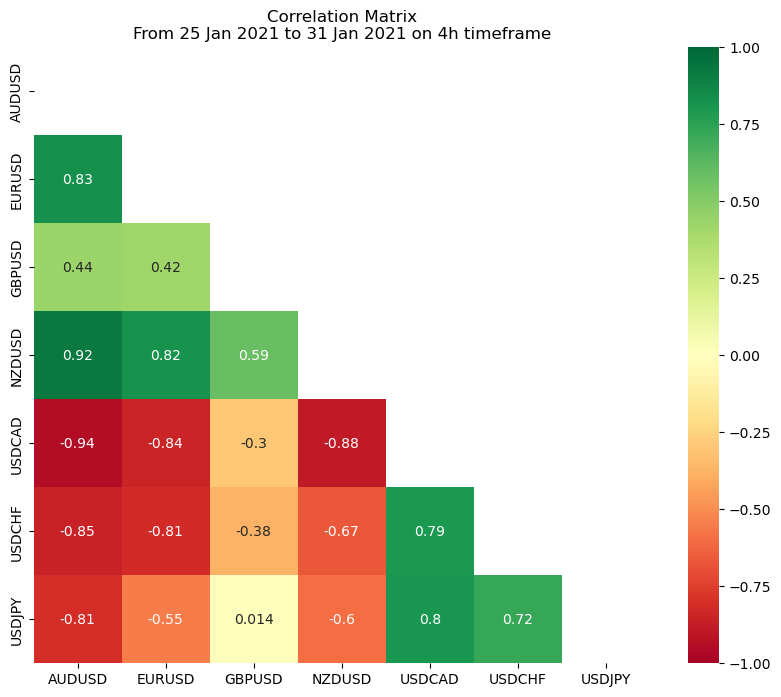

In [22]:
# Initialize the Market object
market = Market(market_data_generator=MarketDataGenerator())

# Timeframe choice
timeframe_choice = 'tick'  # Dukascopy supports only tick data

# Function to fetch and analyze data with caching
def fetch_and_analyze(timeframe_choice, start_date, end_date):
    start_date_str = start_date.strftime('%d %b %Y')
    end_date_str = end_date.strftime('%d %b %Y')
    
    # Fetch data from Dukascopy with caching
    data_frames = []
    for pair in forex_pairs:
        print(f"Fetching tick data for {pair} from Dukascopy from {start_date_str} to {end_date_str}")
        
        md_request = MarketDataRequest(
            start_date=start_date,
            finish_date=end_date,
            category='fx',
            fields=['bid', 'ask'],
            freq=timeframe_choice,
            data_source='dukascopy',
            tickers=[pair],
            cache_algo='cache_algo_return',  # Use cache algorithm for fetching and saving data
            cut='NYC'  # Adjust time cut to match trading hours
        )
        
        try:
            # First attempt to fetch the data and cache it
            df = market.fetch_market(md_request)
            
            # Ensure column names match the expected format
            expected_bid_column = f'{pair}.bid'
            expected_ask_column = f'{pair}.ask'
            
            if df is not None and expected_bid_column in df.columns and expected_ask_column in df.columns:
                df['price'] = (df[expected_bid_column] + df[expected_ask_column]) / 2  # Calculate the mid price
                df = df[['price']].resample(new_timeframe).mean()
            else:
                print(f"Warning: No valid data found for {pair} from {start_date_str} to {end_date_str}")
                continue
            
            data_frames.append(df)

            # Attempt to read from cache after the initial load
            cached_df = market.fetch_market(md_request)
            if cached_df is not None:
                print(f"Data for {pair} retrieved from Redis cache from {start_date_str} to {end_date_str}")

        except Exception as e:
            print(f"Error fetching data for {pair}: {e}")
            continue
    
    # Combine all forex pairs into a single DataFrame
    if data_frames:
        combined_df = pd.concat(data_frames, axis=1)
        combined_df.columns = forex_pairs
        combined_df.dropna(inplace=True)
        
        # Calculate the correlation matrix
        correlation_matrix = combined_df.corr()
        
        # Plot
        plt.figure(figsize=(10, 8))
        mask = np.zeros_like(correlation_matrix)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
        plt.title(f'Correlation Matrix\nFrom {start_date_str} to {end_date_str} on {new_timeframe} timeframe')
        plt.show()
    else:
        print("No valid data found for any of the forex pairs.")

# Execute
fetch_and_analyze(timeframe_choice, start_date, end_date)